## Part 1. Data Processing and Feature Extraction

In [24]:
from IPython.display import clear_output

### A.1 Data Loading: Collect each directory into Single CSV for weather, lightning datasets 

In [ ]:
import os
import shutil
import pandas as pd

FIRE_RECORD = "fp-historical-wildfire-data-2006-2024.csv"
WEATHER_STATION_DIRECTORY = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/keep/"
LIGHTNING_DIRECTORY = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/lightning_data/"

### 1. Aggregate CSV

from concurrent.futures import ThreadPoolExecutor, as_completed

def load_csvs_into_single_file_multithread(
    source_directory, 
    output_file="all_combined.csv", 
    skip_lines=0, 
    thread_count=4
):
    # list all .csv paths
    csv_files = []
    for root, _, files in os.walk(source_directory):
        for file in files:
            if file.lower().endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    
    total_files = len(csv_files)
    if total_files == 0:
        print("No CSV files found. No output created.")
        return None
    
    # Worker: function read a single CSV
    def read_csv_file(file_path, skip):
        """
        Reads a CSV file with optional skiprows, returning the DataFrame.
        Raises any exception to be handled by caller.
        """
        return pd.read_csv(file_path, encoding='utf-8', low_memory=False, skiprows=skip)
    
    # ThreadPoolExecutor to read files in parallel
    dfs = []
    success_count = 0
    
    print(f"Found {total_files} CSV files. Using {thread_count} thread(s) for parallel loading...\n")
    with ThreadPoolExecutor(max_workers=thread_count) as executor:
        # Submit each file to the pool
        future_to_path = {
            executor.submit(read_csv_file, fpath, skip_lines): fpath
            for fpath in csv_files
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_path):
            file_path = future_to_path[future]
            try:
                df = future.result()  # If an exception occurred, it raises here
                dfs.append(df)
                success_count += 1
                print(f"[Loaded] {file_path} ({success_count}/{total_files})")
            except Exception as e:
                print(f"[Failed] {file_path} — Error: {e}")
    
    # 3. If we have at least one loaded DataFrame, combine them
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df.to_csv(output_file, index=False)
        
        print(f"\nSuccessfully loaded [{success_count}/{total_files}] CSV files.")
        print(f"Combined DataFrame has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")
        print(f"Saved merged output to '{output_file}'.")
        return combined_df
    else:
        print("\nNo CSV files loaded successfully. No output created.")
        return None


# Aggregate all data into common csv, only run first time

# lightning_combined = load_csvs_into_single_file_multithread(
#     source_directory=LIGHTNING_DIRECTORY,
#     output_file="all_combined_lightning.csv",
#     skip_lines=2,
#     thread_count=40
# )
# weather_station_combined = load_csvs_into_single_file_multithread(
#     source_directory=LIGHTNING_DIRECTORY,
#     output_file="all_combined_weatherstation.csv",
#     skip_lines=2,
#     thread_count=40
# )




### Data Realization

Data Source 1: Fire Dataset, ground truth of all exsiting fires of Alberta province, are recorded in high precision Latitude and Longtitude and span the map.
- Latitude and longitute labelling.
- Thousands of fires per year.
- Spanning from 1800 - 2025
- Each represent a ground truth point that the training must predict.

Data Source 2: Government Weather Station Dataset, archive of Canadian Weather station, that collect accurate tempreature and rainfall data instead of weather prediction.
- Latitude and longitute labelling. 
- 600 weather stations
- Spanning from 1800 - 2025
- Very few have complete daily data. High Null Rate: 40%

Data Source 3: Daily Lightning Frequency Dataset, arhive of global lightning data with latatude and longtitude labelling.
- Latitude and longitute labelling.
- Millions of lightnings per year.
- Wide Range of Lightning Span, covering almost every location of the country. Data needs to be aggregated statistically or clustered. 

Problems Facing:
- Partially include Latitude and Longtitude of Fire Dataset
- Sptial and Temporal Searching required to assign common ID to weather, lightning, population, and firecase dataset


In [ ]:
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
# Load Data Sources
weather_df = pd.read_csv("all_combined_weatherstation.csv", encoding='utf-8', low_memory=False)
lightning_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/combined_alberta_lightning.csv", encoding='utf-8', low_memory=False)
wildfire_df = pd.read_csv("fp-historical-wildfire-data-2006-2024.csv", encoding='utf-8', low_memory=False)
cities_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/population/canadian_cities_with_coords.csv")

# Verify Data Source 1: Wildfire Dataset
print("Wildfire Dataset Overview")
print("- Total Fires:", len(wildfire_df))
print("- Latitude Nulls:", wildfire_df['LATITUDE'].isnull().sum())
print("- Longitude Nulls:", wildfire_df['LONGITUDE'].isnull().sum())
print("- Year Range:", wildfire_df['YEAR'].min(), "-", wildfire_df['YEAR'].max())

# Verify Data Source 2: Weather Station Dataset
print("\nWeather Station Dataset Overview")
print("- Total Stations:", weather_df['Station Name'].nunique())
print("- Latitude Nulls:", weather_df['Latitude (y)'].isnull().sum())
print("- Longitude Nulls:", weather_df['Longitude (x)'].isnull().sum())
print("- Date Range:", weather_df['Year'].min(), "-", weather_df['Year'].max())
print("- Data Completeness:", weather_df.isnull().mean().mean()*100, "% null values")

# Verify Data Source 3: Lightning Frequency Dataset
print("\nLightning Dataset Overview")
print("- Total Lightning Strikes:", len(lightning_df[lightning_df["TOTAL_COUNT"] > 0]))
print("- Latitude Nulls:", lightning_df['CENTERLON'].isnull().sum())
print("- Longitude Nulls:", lightning_df['CENTERLAT'].isnull().sum())
print("- Date Range:", lightning_df['ZDAY'][:-4].min(), "-", lightning_df['ZDAY'][:-4].max())

# Problems Facing
print("\nData Integration Issues")
# Checking partial inclusion of latitude and longitude in wildfire dataset
partial_lat_long = wildfire_df[['LATITUDE', 'LONGITUDE']].isnull().any(axis=1).sum()
print("- Fires with partial/missing coordinates:", partial_lat_long)

# Spatial-temporal searching notice
print("- Spatial and Temporal Searching needed to integrate datasets.")

# GeoDF for lightning points
gdf_lightning = gpd.GeoDataFrame(
    lightning_df,
    geometry=gpd.points_from_xy(lightning_df["CENTERLON"], lightning_df["CENTERLAT"]),
    crs="EPSG:4326"
)

urban_coords = cities_df[['latitude', 'longitude']].to_numpy()
urban_tree = cKDTree(urban_coords)

# Compute nearest urban center
# def get_distance_to_urban(lat, lon):
#     dist, idx = urban_tree.query([lat, lon], k=1)
#     # also return the population density of the nearest urban center using its idx
#     urban_density = cities_df.iloc[idx]['Population density per square kilometre, 2021']
#     dwellings = cities_df.iloc[idx]['Total private dwellings, 2021']
#     urban_type = cities_df.iloc[idx]['Geographic area type']

#     return dist, urban_type, urban_density, dwellings # in degrees, multiply by ~111 km/deg for rough estimate

# Apply to your df
# weather_lat_col="Latitude (y)"
# weather_lon_col="Longitude (x)"
# fire_lat_col="LATITUDE"
# fire_lon_col="LONGITUDE"
    
# wildfire_df[['dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
#     wildfire_df.apply(lambda row: get_distance_to_urban(row[weather_lat_col], row[weather_lon_col]), axis=1).tolist(),
#     index=wildfire_df.index
# )
# wildfire_df['dist_to_urban_km'] = wildfire_df['dist_to_urban_deg'] * 111 # rough km conversion

# population_infused = wildfire_df.copy()
# population_infused.to_csv("Population_Infused")

# GeoDF for urban centers (optional: size by density)
gdf_urban = gpd.GeoDataFrame(
    cities_df,
    geometry=gpd.points_from_xy(cities_df["longitude"], cities_df["latitude"]),
    crs="EPSG:4326"
)
def plot_raw_df():
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 3 maps + 1 composite
    axes = axes.flatten()


Wildfire Dataset Overview
- Total Fires: 26551
- Latitude Nulls: 0
- Longitude Nulls: 0
- Year Range: 2006 - 2024

Weather Station Dataset Overview
- Total Stations: 617
- Latitude Nulls: 0
- Longitude Nulls: 0
- Date Range: 2007 - 2024
- Data Completeness: 50.40384657391092 % null values

Lightning Dataset Overview
- Total Lightning Strikes: 33384
- Latitude Nulls: 0
- Longitude Nulls: 0
- Date Range: 20000510 - 20240918

Data Integration Issues
- Fires with partial/missing coordinates: 0
- Spatial and Temporal Searching needed to integrate datasets.


/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:956: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:956: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/tmp/ipykernel_

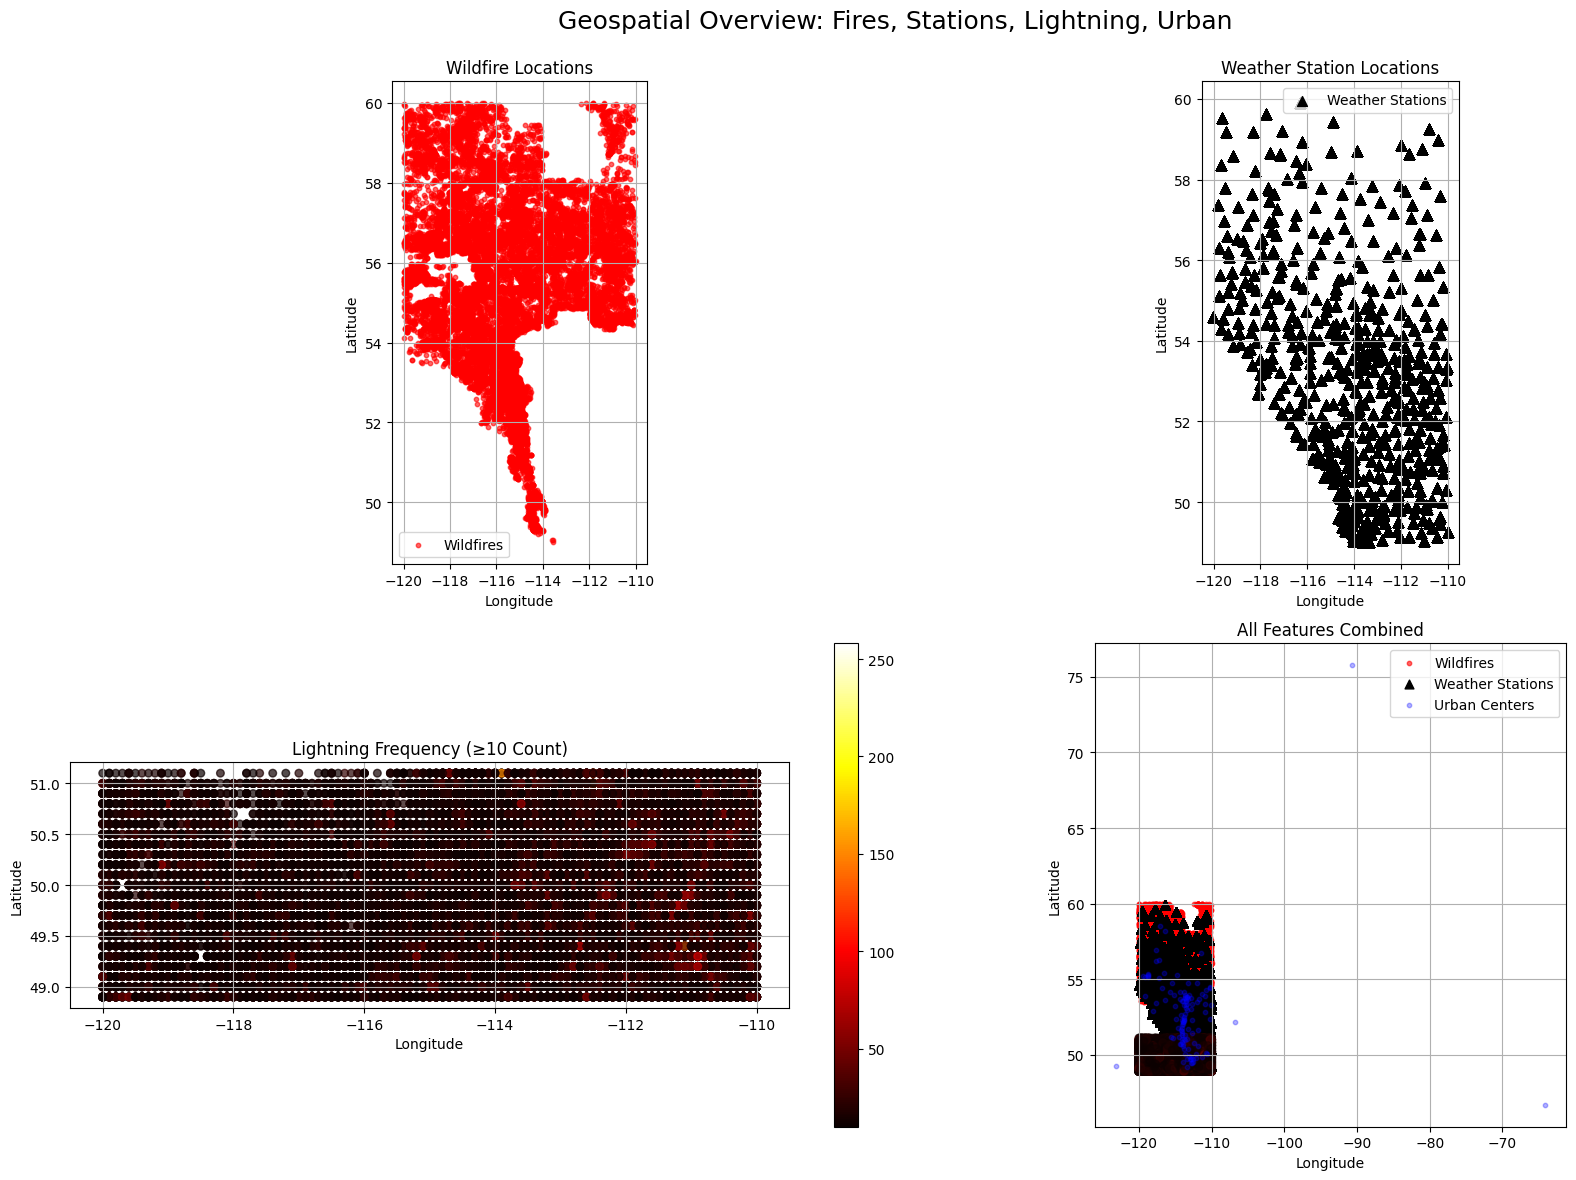

<Figure size 640x480 with 0 Axes>

In [82]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_geospatial_summary(wildfire_df, weather_df, lightning_df, cities_df):
    """
    Plots 4 subplots:
        1. Wildfire locations
        2. Weather station locations
        3. Lightning strike frequency (≥10)
        4. Composite map with all layers

    Args:
        wildfire_df (pd.DataFrame): Wildfire records with LATITUDE and LONGITUDE
        weather_df (pd.DataFrame): Weather station data with Latitude (y) and Longitude (x)
        lightning_df (pd.DataFrame): Lightning strike data with TOTAL_COUNT
        cities_df (pd.DataFrame): City data with lat/lon and urban info
    """
    ### --- GeoDataFrames ---

    gdf_fire = gpd.GeoDataFrame(
        wildfire_df,
        geometry=gpd.points_from_xy(wildfire_df["LONGITUDE"], wildfire_df["LATITUDE"]),
        crs="EPSG:4326"
    )

    gdf_weather = gpd.GeoDataFrame(
        weather_df,
        geometry=gpd.points_from_xy(weather_df["Longitude (x)"], weather_df["Latitude (y)"]),
        crs="EPSG:4326"
    )

    # Filter Alberta & significant lightning
    alberta_bounds = {
        "lat_min": 48.9, "lat_max": 60.0,
        "lon_min": -120.0, "lon_max": -110.0
    }
    df_lightning_filtered = lightning_df[
        (lightning_df["CENTERLAT"] >= alberta_bounds["lat_min"]) &
        (lightning_df["CENTERLAT"] <= alberta_bounds["lat_max"]) &
        (lightning_df["CENTERLON"] >= alberta_bounds["lon_min"]) &
        (lightning_df["CENTERLON"] <= alberta_bounds["lon_max"]) &
        (lightning_df["TOTAL_COUNT"] >= 10)
    ]
    gdf_lightning = gpd.GeoDataFrame(
        df_lightning_filtered,
        geometry=gpd.points_from_xy(df_lightning_filtered["CENTERLON"], df_lightning_filtered["CENTERLAT"]),
        crs="EPSG:4326"
    )

    gdf_urban = gpd.GeoDataFrame(
        cities_df,
        geometry=gpd.points_from_xy(cities_df["longitude"], cities_df["latitude"]),
        crs="EPSG:4326"
    )

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    # Subplot 0: Wildfires
    ax0 = axes[0]
    gdf_fire.plot(ax=ax0, color='red', alpha=0.6, markersize=10, label='Wildfires')
    ax0.set_title("Wildfire Locations")
    ax0.set_xlabel("Longitude")
    ax0.set_ylabel("Latitude")
    ax0.legend()
    ax0.grid(True)

    # Subplot 1: Weather Stations
    ax1 = axes[1]
    gdf_weather.plot(ax=ax1, color='black', marker='^', markersize=50, label='Weather Stations')
    ax1.set_title("Weather Station Locations")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.legend()
    ax1.grid(True)

    # Subplot 2: Lightning
    ax2 = axes[2]
    gdf_lightning.plot(ax=ax2, column="TOTAL_COUNT", cmap="hot", markersize=30, alpha=0.7, legend=True)
    ax2.set_title("Lightning Frequency (≥10 Count)")
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True)

    # Subplot 3: Composite
    ax3 = axes[3]
    gdf_fire.plot(ax=ax3, color='red', markersize=10, alpha=0.6, label='Wildfires')
    gdf_weather.plot(ax=ax3, color='black', marker='^', markersize=40, label='Weather Stations')
    gdf_lightning.plot(ax=ax3, column="TOTAL_COUNT", cmap="hot", markersize=30, alpha=0.5, legend=False)
    gdf_urban.plot(ax=ax3, color='blue', markersize=10, alpha=0.3, label='Urban Centers')

    ax3.set_title("All Features Combined")
    ax3.set_xlabel("Longitude")
    ax3.set_ylabel("Latitude")
    ax3.legend()
    ax3.grid(True)

    # Final layout
    plt.suptitle("Geospatial Overview: Fires, Stations, Lightning, Urban", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


    ### --- Final Display ---
    plt.suptitle("Spatiotemporal Summary: Fires, Lightning, Urban, Weather", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

plot_geospatial_summary(
    wildfire_df=wildfire_df,
    weather_df=weather_df,
    lightning_df=lightning_df,
    cities_df=cities_df
)


### Initial Clustering to visualize data distribution

- **Geospatial Processing:**
  - Geopandas used to create geospatial dataframes (`GeoDataFrame`) from both wildfire and weather station datasets.
  - Confirmed spatial accuracy by ensuring weather stations fall strictly within the defined Alberta geographical bounds.

- **Wildfire-to-Weather Station Clustering:**
  - Applied the `pairwise_distances_argmin_min` function to assign each wildfire incident to its closest weather station, effectively clustering wildfires spatially based on proximity.

- **Visualization:**
  - A clear, color-coded scatter plot using Matplotlib, distinguishing wildfires by their nearest weather station.
  - Weather stations visually represented with distinct markers, enabling easy interpretation of wildfire clusters relative to weather station locations.

- **Station Identification:**
  - Created mapping dictionaries linking station IDs to their corresponding names, facilitating easier interpretation and further analysis.

Weather stations after Alberta + bounds filter: 651
rainbow length 311


/tmp/ipykernel_576881/2923925798.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_ncar', n)


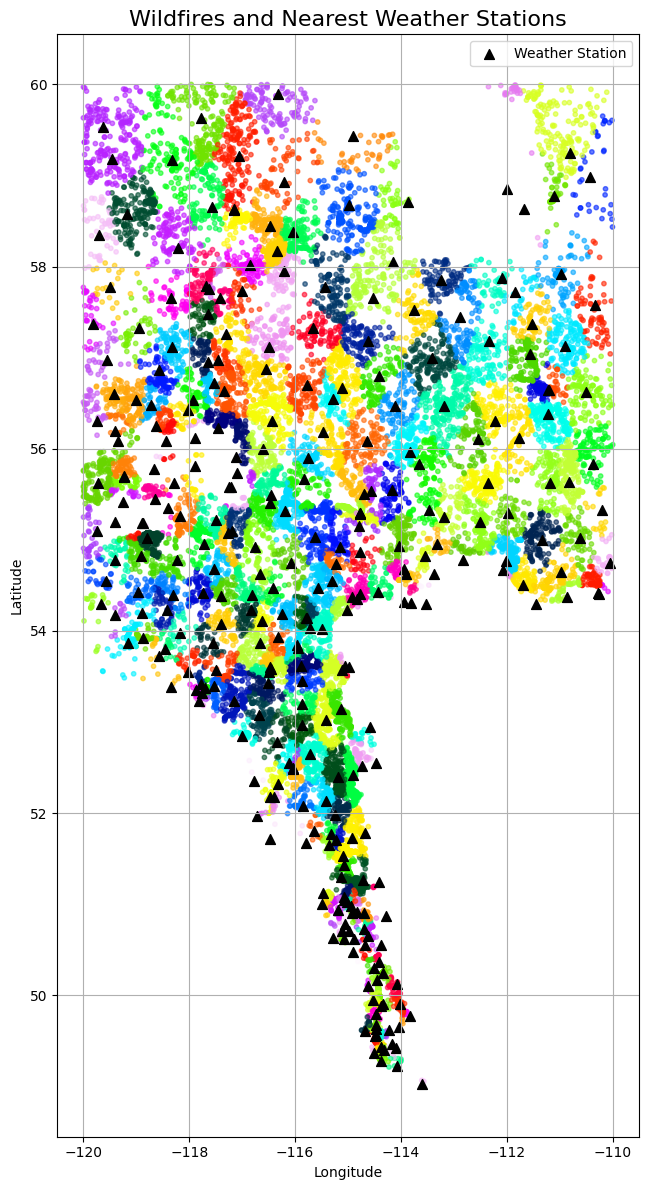

{'1814': 'AURORA LO', '1815': 'BASELINE LO', '1822': 'BLACKSTONE LO', '1823': 'BRAZEAU LO', '1848': 'CLEARWATER', '27260': 'ELK RIVER AFS', '8712': 'ROCKY MTN HOUSE (AUT)', '1967': 'ST LINA', '30643': 'VIOLET GROVE CS', '2017': 'WINFIELD', '1799': 'HORBURG', '55338': 'PIBROCH AGCM', '8723': 'COALCAMP CREEK', '43561': 'LEEDALE AGDM', '2108': 'LOBSTICK AUBUCHON', '10105': 'SUNDRE A', '8753': 'BEAUVAIS PARK', '42443': 'COCHRANE BIGHILL CREEK', '2231': 'CONNELLY CREEK', '31089': 'COWLEY TANNER', '2239': 'FIVE MILE CREEK', '48468': 'PRIDDIS OBSERVATORY', '43363': 'WILDCAT HILLS', '2363': 'BALDY LO', '27295': 'BARRIER LAKE', '2366': 'BEAVER MINES', '2365': 'BIGHORN DAM', '2368': 'BLUEHILL LO', '10222': 'BOW VALLEY', '8924': 'BURNS CREEK', '2375': 'CARBONDALE LO', '2377': 'CASTLE', '2379': 'CLINE LO', '8914': 'COMPRESSION RIDGE', '8724': 'COX HILL', '10690': 'CROWSNEST CREEK', '10890': 'CROWSNEST', '2386': 'ELBOW RS', '8825': 'FALLEN TIMBER', '8824': 'FORGET ME NOT MOUNTAIN', '27716': "GOAT'S

In [ ]:
# Re-import required libraries after code execution environment reset
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

alberta_bounds = {
    "lat_min": 48.9,
    "lat_max": 60.0,
    "lon_min": -120.0,
    "lon_max": -110.0
}


# Define the class again
class WildfireWeatherAnalysis:
    def __init__(self, wildfire_file, weather_file):
        self.wildfire_file = wildfire_file
        self.weather_file = weather_file
        self.wildfire_df = None
        self.clustered_gdf = None
        self.weather_gdf = None

    def load_data(self):
        # Load wildfire data
        if self.wildfire_file.endswith('.xlsx'):
            excel_file = pd.ExcelFile(self.wildfire_file)
            self.wildfire_df = pd.read_excel(excel_file, sheet_name="2006-2024")
        elif self.wildfire_file.endswith('.csv'):
            self.wildfire_df = pd.read_csv(self.wildfire_file)
        else:
            raise ValueError("Unsupported wildfire file format")

        # Load weather station data
        weather_df = pd.read_csv(self.weather_file, skiprows=0, quotechar='"')
        weather_df = weather_df[weather_df["Province"].str.upper() == "ALBERTA"]

        # Ensure stations are within Alberta
        weather_df["Station ID"] = weather_df["Station ID"].astype(str)
        kept = ['1977', '48550', '8884', '2823', '48949', '2586', '46827', '10225', '2511', '2613', '51497', '27031', '2663', '41785', '51377', '2605', '2553', '51500', '50920', '27652', '2767', '30726', '2693', '10864', '1805', '2770', '2797', '2471', '2502', '10105', '2479', '2788', '2704', '27212', '46447', '27037', '32455', '2402', '2173', '42727', '43151', '53998', '8893', '2416', '42443', '8838', '2323', '26888', '46910', '9010', '32333', '2745', '2750', '2732', '1823', '27713', '1984', '2395', '2685', '2301', '52258', '2593', '50757', '2489', '2102', '27219', '55538', '27825', '45887', '2656', '43581', '10689', '8924', '6853', '53078', '53100', '2570', '8824', '27455', '47090', '2407', '2578', '2562', '50149', '47748', '8819', '47073', '50940', '2604', '1898', '47147', '27261', '31027', '2368', '42726', '46127', '2339', '27655', '2564', '2460', '46847', '32394', '2677', '2134', '2517', '32255', '51498', '46132', '51578', '1920', '1953', '2722', '1825', '2626', '27715', '10907', '51858', '2690', '51422', '1896', '53098', '27041', '2001', '32149', '50622', '2092', '8804', '2764', '2700', '46811', '2431', '2169', '27658', '8857', '2454', '53999', '2409', '46787', '2657', '50937', '27828', '1884', '2556', '44266', '43147', '51838', '32256', '1839', '2274', '55338', '27213', '46851', '55018', '31608', '2423', '50129', '2086', '2814', '2596', '51444', '42728', '54358', '45748', '45927', '8859', '47107', '2377', '32253', '31411', '31447', '50939', '32454', '2072', '2694', '46849', '31409', '46729', '2648', '1814', '2432', '2519', '8918', '50922', '2224', '2103', '47068', '2795', '2635', '45767', '2050', '2528', '45907', '1881', '8712', '30643', '41784', '2405', '2273', '8830', '46467', '2621', '9609', '10708', '2231', '2765', '2829', '50918', '50921', '31427', '32458', '2538', '31468', '6860', '2731', '2737', '43783', '47089', '2542', '2832', '27650', '42731', '2790', '2590', '2144', '50623', '1799', '2624', '30495', '46468', '2386', '2594', '1967', '8837', '2778', '1835', '47076', '46128', '2440', '53738', '32456', '47087', '2601', '2113', '2746', '1812', '2016', '2597', '1857', '47070', '2457', '46914', '32274', '46130', '46129', '8872', '2025', '2174', '50128', '30641', '2809', '2482', '50028', '30543', '2347', '2500', '54478', '47108', '1935', '10104', '47071', '1915', '8900', '29926', '46807', '2813', '2680', '47128', '2819', '49949', '2400', '30055', '53099', '51499', '2666', '49968', '10906', '42724', '2108', '2655', '2461', '49268', '2567', '42703', '27653', '2392', '2668', '46852', '49490', '31207', '46913', '27492', '2112', '2425', '31089', '2263', '2467', '8917', '2503', '46810', '2523', '2504', '55419', '53718', '2312', '2632', '2573', '46734', '47747', '2654', '31408', '41757', '2276', '49048', '46470', '2017', '51840', '46912', '2689', '2757', '50311', '8753', '2150', '2515', '2255', '2485', '46927', '53918', '2462', '2141', '2258', '2219', '50917', '43150', '2803', '52982', '9015', '46867', '2429', '10222', '2658', '1801', '47077', '2068', '2459', '45727', '2411', '27656', '2684', '9611', '32231', '2492', '46469', '10725', '46327', '2227', '27216', '27295', '2712', '1822', '44746', '10665', '50938', '32459', '32232', '46848', '45947', '10915', '26971', '2438', '8895', '46131', '42729', '32257', '43148', '47047', '2634', '2721', '2821', '55418', '2171', '8723', '43580', '43363', '49369', '30310', '45847', '47767', '2122', '51898', '2521', '2510', '2675', '2783', '2782', '2539', '31410', '51501', '2366', '43164', '46732', '46808', '2755', '48948', '30669', '2762', '2239', '46907', '31412', '45749', '2375', '32313', '53198', '2628', '2718', '2572', '2794', '27200', '2641', '27214', '2735', '10930', '45647', '30907', '27793', '1904', '49948', '27260', '47110', '1990', '2205', '42730', '2481', '46850', '45867', '2701', '2513', '2804', '2673', '46767', '2667', '43561', '41783', '2452', '2811', '2404', '50777', '10223', '27030', '27029', '2363', '47075', '48975', '2761', '42283', '2736', '1868', '27262', '2800', '27217', '2719', '2078', '27716', '2592', '2120', '45948', '27845', '29633', '2379', '10700', '2332', '2140', '10928', '10793', '8791', '32395', '8856', '43149', '42164', '2247', '49368', '30347', '46887', '9410', '47072', '46730', '2493', '2218', '1865', '31588', '2486', '2614', '46731', '2279', '2537', '1958', '2674', '45747', '42163', '31469', '2295', '8916', '2410', '2393', '52358', '32273', '52200', '46909', '1828', '2793', '31288', '46471', '46809', '1848', '26870', '27040', '1815', '2315', '9604', '47067', '51841', '2781', '2639', '10183', '1859', '51440', '10693', '47074', '54718', '32461', '27038', '1873', '49928', '54000', '42725', '27036', '50919', '2180', '27018', '46928', '48468', '8825', '47069', '10889', '47727', '52459', '8915', '1886', '2084', '46908', '55478', '10932', '10691', '27211', '47787', '29573', '49050', '2265', '27378', '32460', '8920', '2508', '31528', '31414', '10978', '1872', '30433', '2580', '2123', '2830', '46911', '6865', '1974', '1870', '27199', '50923', '2650', '2622', '8724', '2577', '2145', '49049', '2726', '2490', '43560', '27657', '2545', '47088', '31413', '51839', '51899', '32453', '2739', '2133', '27218', '53358', '46733', '27263', '1829', '51758', '9610', '6854', '2501', '31407', '32230', '52458', '32457', '8919', '2779', '10690', '2396', '1843', '9608', '42723', '26850', '47109', '2561', '47127', '2818', '6863', '2417', '1840', '46812', '2649', '31198', '2806', '52478', '50430', '2543', '10890', '2544', '8855', '27654', '55118', '9436', '2740', '55098', '27331', '51502', '32254', '46853', '8851', '2365', '2522', '32433', '8914']
        weather_df = weather_df[weather_df['Station ID'].astype(str).isin(kept)]
        weather_df = weather_df.dropna(subset=["Latitude (Decimal Degrees)", "Longitude (Decimal Degrees)"])
        weather_df = weather_df[
            (weather_df["Province"].str.upper() == "ALBERTA") &
            (weather_df["Latitude (Decimal Degrees)"].between(alberta_bounds["lat_min"], alberta_bounds["lat_max"])) &
            (weather_df["Longitude (Decimal Degrees)"].between(alberta_bounds["lon_min"], alberta_bounds["lon_max"]))
        ]
        print("Weather stations after Alberta + bounds filter:", len(weather_df))


        self.weather_gdf = gpd.GeoDataFrame(
            weather_df,
            geometry=gpd.points_from_xy(weather_df["Longitude (Decimal Degrees)"], weather_df["Latitude (Decimal Degrees)"]),
            crs="EPSG:4326"
        )

        self.cluster_wildfires_analyze()

        self.weather_gdf = self.weather_gdf[self.weather_gdf["Station ID"].isin(self.wildfire_df["Station ID"].to_list())]


    def plot_clusters_with_weather(self):
        fig, ax = plt.subplots(figsize=(15, 12))

        # Use same color mapping logic
        station_ids = self.clustered_gdf['Station ID'].astype(str).unique()
        n = len(station_ids)
        print("rainbow length", n)
        cmap = cm.get_cmap('gist_ncar', n)
        color_map = {station: mcolors.rgb2hex(cmap(i)) for i, station in enumerate(station_ids)}
        self.clustered_gdf['color'] = self.clustered_gdf['Station ID'].astype(str).map(color_map)

        self.clustered_gdf.plot(ax=ax, color=self.clustered_gdf['color'], markersize=10, alpha=0.6)
        self.weather_gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)

        ax.set_title("Wildfires and Nearest Weather Stations", fontsize=16)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return station_ids


    def cluster_wildfires_analyze(self):
        # Coordinates of weather station and wildfire are extracted
        wildfire_coords = self.wildfire_df[['LATITUDE', 'LONGITUDE']].dropna().copy()
        weather_coords = self.weather_gdf[['Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)']].to_numpy()

        # Find closest station of each station
        station_ids = self.weather_gdf['Station ID'].to_numpy()
        fire_coords = wildfire_coords[['LATITUDE', 'LONGITUDE']].to_numpy()
        closest_indices, _ = pairwise_distances_argmin_min(fire_coords, weather_coords)

        # Map each wildfire to its nearest station ID
        wildfire_coords['Station ID'] = station_ids[closest_indices]
        
        # Merge the cluster assignment back into original df
        self.wildfire_df = self.wildfire_df.merge(wildfire_coords[['LATITUDE', 'LONGITUDE', 'Station ID']], 
                                on=['LATITUDE', 'LONGITUDE'], 
                                how='left')
        
        self.clustered_gdf = gpd.GeoDataFrame(
            wildfire_coords,
            geometry=gpd.points_from_xy(wildfire_coords['LONGITUDE'], wildfire_coords['LATITUDE']),
            crs="EPSG:4326"
        )

        return wildfire_coords

    def lookup_station_names(self, list_of_id):
        # create fire station name to ID lookup table to be used when processing individual weather stations
        df = self.weather_gdf.copy()
        df = df[["Name", "Station ID"]].copy()

        # Filter to only those in the provided list
        matched = df[df['Station ID'].isin(list_of_id)]
        
        # Return as a dictionary {id: name}
        return dict(zip(matched['Station ID'], matched['Name'])), dict(zip(matched['Name'], matched['Station ID'])),



# Instantiate and run the analysis
analysis = WildfireWeatherAnalysis(
    wildfire_file="fp-historical-wildfire-data-2006-2024.csv",
    weather_file="StationInventoryEN.csv"
)
analysis.load_data()

clustered_fire_df = analysis.cluster_wildfires_analyze()
filtered_stationID = analysis.plot_clusters_with_weather()

id2name_lookup, name2id_lookup = analysis.lookup_station_names(filtered_stationID)
print(id2name_lookup, name2id_lookup)
filtered_stationName = []
for id in filtered_stationID:
    filtered_stationName.append(id2name_lookup.get(id))
print(filtered_stationName)


### A.3 NULL TEST
#### Statistical Analysis are performed to evaluate the quality of weather station data on each category.

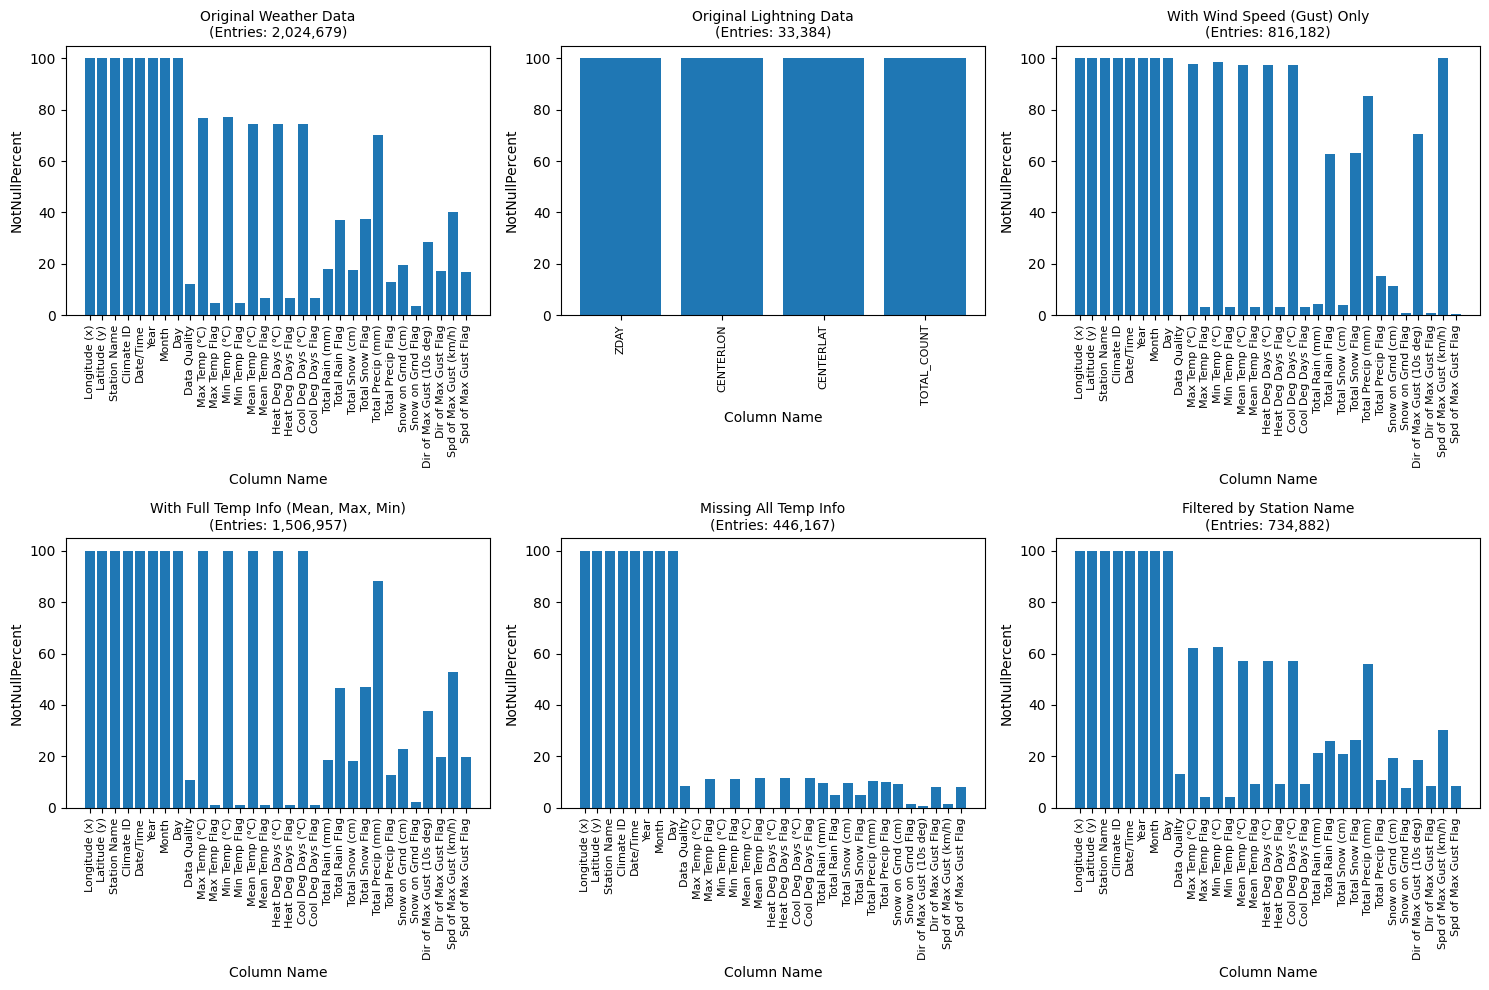

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


def column_empty_report(df):
    """
    Returns a DataFrame summarizing how many rows in each column are empty 
    (NaN) and the percentage of empties out of total rows.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame to analyze.
    
    Returns
    -------
    pd.DataFrame
        A table with columns:
            'ColumnName'   : The original column name
            'EmptyCount'   : Number of rows that are NaN in this column
            'EmptyPercent' : Percentage of rows that are NaN (0.00 to 100.00)
            'Report'       : String showing both the count and percentage
    """
    total_rows = len(df)
    results = []

    for col in df.columns:
        # Count how many rows are NaN in this column
        empty_count = df[col].isna().sum()
        
        # Calculate percentage (avoid divide-by-zero if DF is empty)
        if total_rows > 0:
            empty_percent = (empty_count / total_rows) * 100
        else:
            empty_percent = 0.0
        
        results.append({
            "ColumnName": col,
            "EmptyCount": empty_count,
            "EmptyPercent": round(empty_percent, 2)
        })
        
    # Return as a DataFrame
    return pd.DataFrame(results)

import math
import matplotlib.pyplot as plt

def plot_two_dataframes(df_tuples):
    n = len(df_tuples)
    if n == 0:
        print("No DataFrames to plot.")
        return

    # Grid layout: 3 columns max
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows), sharey=False)

    # Flatten axes for easy iteration (in case of single row/col)
    if rows == 1:
        axes = [axes] if n == 1 else axes
    else:
        axes = axes.flatten()

    for i, (title, df) in enumerate(df_tuples):
        og_df = df.copy()
        df = column_empty_report(df)
        df["NotNullPercent"] = 100 - df["EmptyPercent"]
        ax = axes[i]

        ax.bar(df["ColumnName"], df["NotNullPercent"])

        # Estimate entry count from percent math
        entry_count = og_df.iloc[:, 0].notna().sum()

        ax.set_title(f"{title}\n(Entries: {entry_count:,})", fontsize=10)
        ax.set_xlabel("Column Name")
        ax.set_ylabel("NotNullPercent")
        ax.tick_params(axis='x', labelrotation=90, labelsize=8)

    # Turn off any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


weather_df_validity = column_empty_report(weather_df)
lightning_df_validity = column_empty_report(lightning_df)
df_with_wind = weather_df[weather_df["Spd of Max Gust (km/h)"].notnull()]
df_without_wind = weather_df[weather_df["Spd of Max Gust (km/h)"].isnull()]
df_without_tmp = weather_df[weather_df["Mean Temp (°C)"].isnull()]
df_without_tmp = df_without_tmp[df_without_tmp["Max Temp (°C)"].isnull()]
df_without_tmp = df_without_tmp[df_without_tmp["Min Temp (°C)"].isnull()]

df_with_tmp = weather_df[weather_df["Mean Temp (°C)"].notnull()]
df_with_tmp = df_with_tmp[df_with_tmp["Max Temp (°C)"].notnull()]
df_with_tmp = df_with_tmp[df_with_tmp["Min Temp (°C)"].notnull()]

df_filtered_tmp = weather_df[weather_df["Station Name"].isin(filtered_stationName)]

df_tuples = [
    ("Original Weather Data", weather_df),
    ("Original Lightning Data", lightning_df),
    ("With Wind Speed (Gust) Only", df_with_wind),
    ("With Full Temp Info (Mean, Max, Min)", df_with_tmp),
    ("Missing All Temp Info", df_without_tmp),
    ("Filtered by Station Name", df_filtered_tmp)
]

plot_two_dataframes(df_tuples)
# print(df_without_tmp)

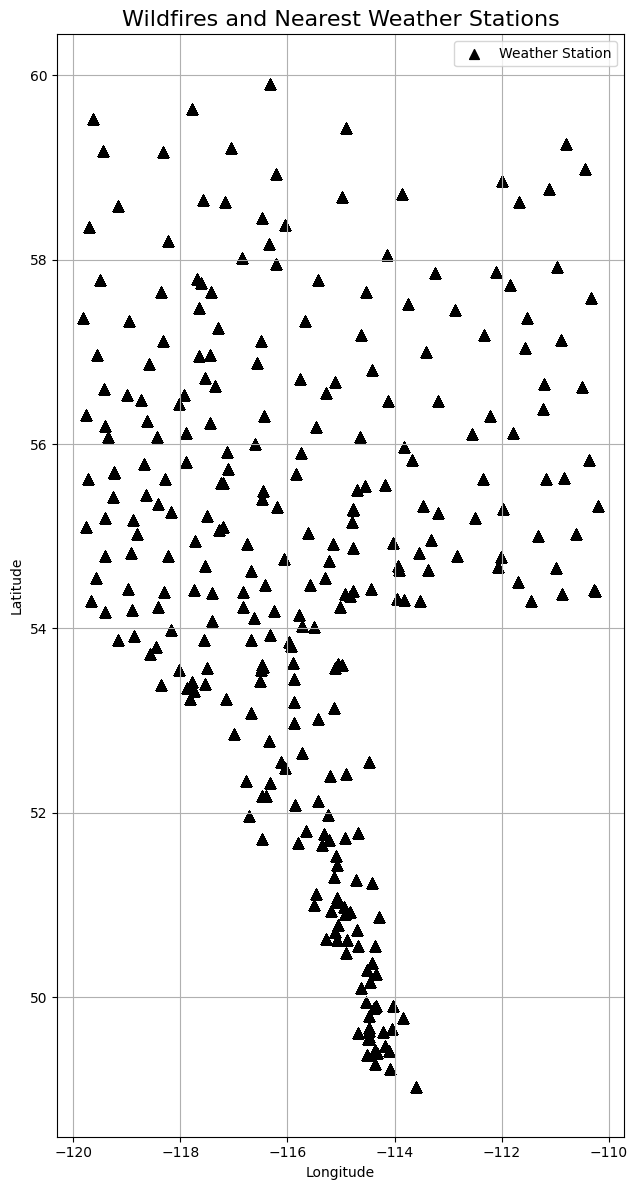

In [29]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def plot_stations(df):
    fig, ax = plt.subplots(figsize=(15, 12))
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude (x)"], df["Latitude (y)"]),
        crs="EPSG:4326"
    )
    gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)

    ax.set_title("Wildfires and Nearest Weather Stations", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_stations(df_filtered_tmp)


## A.2 Wildfire and Weather Station Spatial AnalysisCommon ID Problem: 
There are around 20,000 fires a year, and only 600 weather stations across the Alberta district with accurate recordings., much more fire locations and lightning locations than that the weather station can cover. 

In order to connect exsisting Fire data to weather stations' historical data in Alberta, one must assign a common index system that represent weather condition around the fire location.

1. Clustering Fire Events: To cluster with K-Means clustering where K = Number of DataStation.

2. Closest Neighbour: Identify Regions of Monitoring, associate each Fire Record with a weather station that is closets to it, to reflect the nearby weather data

The goal was to associate historical wildfire incidents in Alberta (2006-2024) with the nearest weather stations and visualize these clusters for further weather analysis.





0        2006-04-02
1        2006-04-03
2        2006-04-03
3        2006-04-03
4        2006-04-03
            ...    
26546    2024-06-28
26547    2024-08-31
26548    2024-07-03
26549    2024-10-06
26550    2024-10-06
Name: Date, Length: 25858, dtype: object ```````````````````````````````````````````````````````````````````````````````````````````````````` 0          2011-01-01
1          2011-01-02
2          2011-01-03
3          2011-01-04
4          2011-01-05
              ...    
2022118    2007-12-27
2022119    2007-12-28
2022120    2007-12-29
2022121    2007-12-30
2022122    2007-12-31
Name: Date, Length: 734882, dtype: object


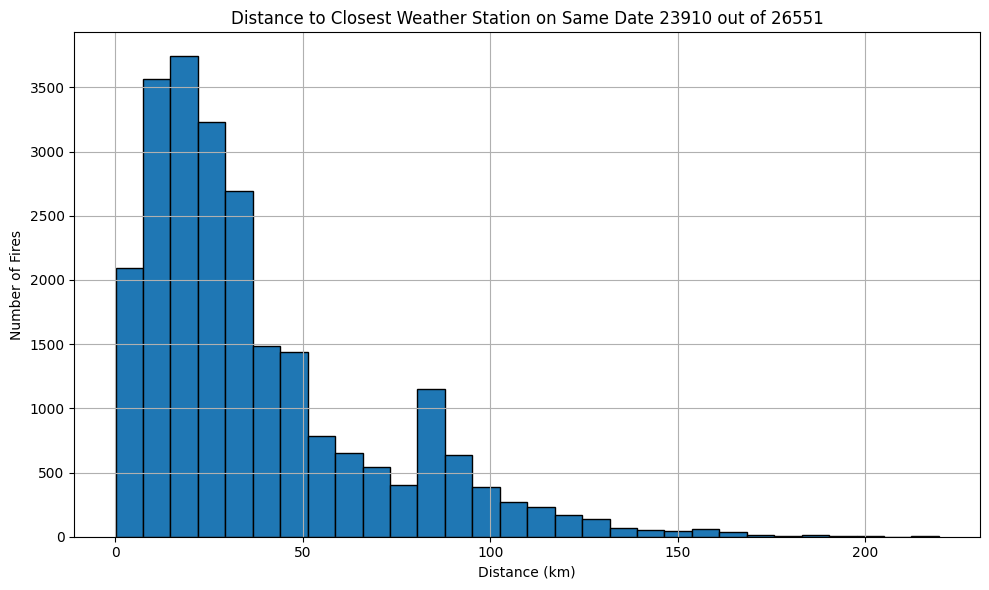

       YEAR FIRE_NUMBER          FIRE_NAME  CURRENT_SIZE SIZE_CLASS  \
0      2006      PWF001                NaN          0.10          A   
1      2006      EWF002                NaN          0.20          B   
2      2006      EWF001                NaN          0.50          B   
3      2006      EWF003                NaN          0.01          A   
4      2006      PWF002                NaN          0.10          A   
...     ...         ...                ...           ...        ...   
26546  2024      HWF053  Semo Lake Complex        709.20          E   
26547  2024      LWF190                NaN          0.01          A   
26548  2024      HWF100                NaN        621.60          E   
26549  2024      HWF180                NaN          0.22          B   
26550  2024      WWF064                NaN          0.01          A   

        LATITUDE   LONGITUDE         FIRE_ORIGIN        GENERAL_CAUSE  \
0      56.249956 -117.181960        Private Land             Resident   
1

In [ ]:
def find_closest_weather_station(wildfire_df, weather_df,
                                 wild_fire_lat="LATITUDE", wild_fire_lon="LONGITUDE",
                                 weather_lat="Latitude (y)", weather_lon="Longitude (x)",
                                 fire_date_col="FIRE_START_DATE", weather_date_col="Date/Time"):
    
    # Parse date columns
    weather_df = weather_df.copy()
    wildfire_df = wildfire_df.copy()
    weather_df["Date"] = pd.to_datetime(weather_df[weather_date_col]).dt.date
    wildfire_df["ParsedDate"] = pd.to_datetime(wildfire_df["FIRE_START_DATE"], errors='coerce')
    
    
    wildfire_df = wildfire_df[wildfire_df["ParsedDate"].notna()]
    wildfire_df["Date"] = wildfire_df["ParsedDate"].dt.date

    weather_by_date = weather_df.groupby("Date")
    print(wildfire_df["Date"], '`'*100, weather_df["Date"])

    # Haversine distance
    def haversine_np(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return 6371 * c  # km

    matched_station_names = []
    matched_distances = []
    matched_Max = []
    matched_Min = []
    matched_Mean = []
    matched_Rain = []
    matched_Snow = []
    matched_Precip = []
    matched_Spd = []

    for idx, fire in wildfire_df.iterrows():
        fire_date = fire["Date"]
        fire_lat = fire[wild_fire_lat]
        fire_lon = fire[wild_fire_lon]

        if pd.isna(fire_lat) or pd.isna(fire_lon):
            matched_station_names.append(None)
            matched_distances.append(np.nan)
            # print(f"Fire ignore, no fire_lat, fire_lon")
            matched_Max.append(np.nan)
            matched_Min.append(np.nan)
            matched_Mean.append(np.nan)
            matched_Rain.append(np.nan)
            matched_Snow.append(np.nan)
            matched_Precip.append(np.nan)
            matched_Spd.append(np.nan)
            continue

        if fire_date not in weather_by_date.groups:
            matched_station_names.append(None)
            matched_distances.append(np.nan)
            # print(f"Fire fire_date, no weather_by_date")
            matched_Max.append(np.nan)
            matched_Min.append(np.nan)
            matched_Mean.append(np.nan)
            matched_Rain.append(np.nan)
            matched_Snow.append(np.nan)
            matched_Precip.append(np.nan)
            matched_Spd.append(np.nan)
            continue

        day_weather = weather_by_date.get_group(fire_date)
        lats = day_weather[weather_lat].values
        lons = day_weather[weather_lon].values

        distances = haversine_np(fire_lon, fire_lat, lons, lats)
        closest_idx = np.argmin(distances)

        matched_weather_row = day_weather.iloc[closest_idx]
        weather_index = matched_weather_row.name  # This is the index in the original weather_df

        # Set fire metadata directly into the matching weather_df row
        weather_df.at[weather_index, "Fire_Occurred"] = True
        weather_df.at[weather_index, "LATITUDE"] = fire.get("LATITUDE")
        weather_df.at[weather_index, "LONGITUDE"] = fire.get("LONGITUDE")
        weather_df.at[weather_index, "Matched_Fire_Start"] = fire.get("FIRE_START_DATE")
        weather_df.at[weather_index, "Matched_Fire_End"] = fire.get("FIRST_EX_DATE")
        weather_df.at[weather_index, "Fuel_Type"] = fire.get("FUEL_TYPE")
        weather_df.at[weather_index, "GENERAL_CAUSE"]  = fire.get("GENERAL_CAUSE")
        matched_station_names.append(day_weather.iloc[closest_idx]["Station Name"])
        matched_Max.append(day_weather.iloc[closest_idx]["Max Temp (°C)"])
        matched_Min.append(day_weather.iloc[closest_idx]["Min Temp (°C)"])
        matched_Mean.append(day_weather.iloc[closest_idx]["Mean Temp (°C)"])
        matched_Rain.append(day_weather.iloc[closest_idx]["Total Rain (mm)"])
        matched_Snow.append(day_weather.iloc[closest_idx]["Total Snow (cm)"])
        matched_Precip.append(day_weather.iloc[closest_idx]["Total Precip (mm)"])
        matched_Spd.append(day_weather.iloc[closest_idx]["Spd of Max Gust (km/h)"])
        
        matched_distances.append(distances[closest_idx])

    # Add matched data to wildfire_df
    wildfire_df["Matched Station Name"] = matched_station_names
    wildfire_df["Distance to Station (km)"]=  matched_distances
    wildfire_df["Max Temp (°C)"] = matched_Max
    wildfire_df["Min Temp (°C)"] = matched_Min
    wildfire_df["Mean Temp (°C)"] = matched_Mean
    wildfire_df["Total Rain (mm)"] = matched_Rain
    wildfire_df["Total Snow (cm)"] = matched_Snow
    wildfire_df["Total Precip (mm)"] = matched_Precip
    wildfire_df["Spd of Max Gust (km/h)"] = matched_Spd
    

    return wildfire_df, weather_df

# Run the function
aggregated_weather_df = df_filtered_tmp.copy()
aggregated_weather_df["Fire_Occurred"] = False
aggregated_weather_df["LATITUDE"] = None
aggregated_weather_df["LONGITUDE"] = None
aggregated_weather_df["Matched_Fire_Start"] = None
aggregated_weather_df["Matched_Fire_End"] = None
aggregated_weather_df["Fuel_Type"] = None
aggregated_weather_df["GENERAL_CAUSE"] = None


wildfire_df_enriched,weather_df_enriched = find_closest_weather_station(wildfire_df, aggregated_weather_df)
wildfire_df_enriched["Matched Station ID"] = wildfire_df_enriched["Matched Station Name"].map(name2id_lookup)
weather_df_enriched = weather_df_enriched[~weather_df_enriched["Max Temp (°C)"].isin([None, "", np.nan])]

# Plot the distance distribution
wildfire_to_ws_distance_df = wildfire_df_enriched["Distance to Station (km)"].dropna()
plt.figure(figsize=(10, 6))
plt.hist(wildfire_to_ws_distance_df, bins=30, edgecolor='black')
plt.title(f"Distance to Closest Weather Station on Same Date {len(wildfire_to_ws_distance_df)} out of {len(wildfire_df)}")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Fires")
plt.grid(True)
plt.tight_layout()
plt.show()

wildfire_df_enriched.to_csv("wildfire_df_enriched")
weather_df_enriched.to_csv("weather_df_enriched")


#### Prepare Model Inpunt Data by Final Aggreagating all fire and non-fire data

In [62]:
def add_lightning_info_to_weather(weather_df, lightning_df,
                                  lightning_lat_col="CENTERLAT", lightning_lon_col="CENTERLON",
                                  lightning_date_col="ZDAY",
                                  weather_lat_col="Latitude (y)", weather_lon_col="Longitude (x)",
                                  fire_lat_col="LATITUDE", fire_lon_col="LONGITUDE",
                                  weather_date_col="Date/Time"):

    # Copy to avoid modifying originals
    weather_df = weather_df.copy()
    lightning_df = lightning_df.copy()

    # Parse dates
    lightning_df["Date"] = pd.to_datetime(lightning_df[lightning_date_col], format="%Y%m%d").dt.date
    weather_df["ParsedDate"] = pd.to_datetime(weather_df[weather_date_col], errors="coerce").dt.date
    weather_df = weather_df[weather_df["ParsedDate"].notna()]

    # Round coordinates for lightning
    lightning_df["lat_r"] = lightning_df[lightning_lat_col].round(1)
    lightning_df["lon_r"] = lightning_df[lightning_lon_col].round(1)

    # Round coordinates for weather (depending on fire occurrence)
    weather_df["lat_r"] = np.where(
        weather_df["Fire_Occurred"],
        weather_df[fire_lat_col].round(1),
        weather_df[weather_lat_col].round(1)
    )

    weather_df["lon_r"] = np.where(
        weather_df["Fire_Occurred"],
        weather_df[fire_lon_col].round(1),
        weather_df[weather_lon_col].round(1)
    )

    # Initialize lightning count columns
    lightning_0_1 = []

    # Loop through weather_df and calculate recent lightning activity
    for idx, row in weather_df.iterrows():
        date = row["ParsedDate"]
        lat = row["lat_r"]
        lon = row["lon_r"]

        # Date range: [date - 7, date)
        start_date = date - pd.Timedelta(days=7)

        recent_lightning = lightning_df[
            (lightning_df["Date"] < date) & (lightning_df["Date"] >= start_date) &
            (lightning_df["lat_r"] == lat) &
            (lightning_df["lon_r"] == lon)
        ]

        count = recent_lightning["TOTAL_COUNT"].sum()
        lightning_0_1.append(count)

    # Add column
    weather_df.drop(columns=["Date", "lat_r", "lon_r"], inplace=True, errors="ignore")

    weather_df["Lightning_Count_0.1deg_7days"] = lightning_0_1

    return weather_df


lightning_infused_df_enriched = add_lightning_info_to_weather(weather_df_enriched, lightning_df)
lightning_infused_df_enriched.to_csv("lightning_infused")

In [64]:
print(len(lightning_infused_df_enriched[lightning_infused_df_enriched["Lightning_Count_0.1deg_7days"] > 0]))
# print(lightning_infused_df_enriched[lightning_infused_df_enriched["Lightning_Count_0.1deg_7days"] > 0])
print(len(lightning_infused_df_enriched[lightning_infused_df_enriched["Fire_Occurred"]]))
fire = lightning_infused_df_enriched[lightning_infused_df_enriched["Fire_Occurred"]]
print(len(fire[fire["Lightning_Count_0.1deg_7days"] > 0]))
print(len(lightning_infused_df_enriched[lightning_infused_df_enriched["GENERAL_CAUSE"] == "Lightning"]))
lightning_infused_df_enriched[lightning_infused_df_enriched["GENERAL_CAUSE"] == "Lightning"]

# 计算有闪电（0.1°范围内）的天气观测数量
num_lightning_obs = len(lightning_infused_df_enriched[lightning_infused_df_enriched["Lightning_Count_0.1deg_7days"] > 0])
print(f"观测中有闪电（0.1°匹配）的数量: {num_lightning_obs}")

# 计算火灾发生的总观测数量
num_fire_obs = len(lightning_infused_df_enriched[lightning_infused_df_enriched["Fire_Occurred"]])
print(f"火灾发生的观测数量: {num_fire_obs}")

# 在火灾观测中，有闪电的数量
fire_df = lightning_infused_df_enriched[lightning_infused_df_enriched["Fire_Occurred"]]
num_fire_with_lightning = len(fire_df[fire_df["Lightning_Count_0.1deg_7days"] > 0])
print(f"火灾观测中有闪电的数量: {num_fire_with_lightning}")

# 计算GENERAL_CAUSE为 "Lightning" 的观测数量
num_general_cause_lightning = len(lightning_infused_df_enriched[lightning_infused_df_enriched["GENERAL_CAUSE"] == "Lightning"])
print(f"GENERAL_CAUSE标记为 'Lightning' 的数量: {num_general_cause_lightning}")

# 如果需要观察这些记录的样例，可以查看前几行
print("GENERAL_CAUSE为 'Lightning' 的记录样例:")
print(lightning_infused_df_enriched[lightning_infused_df_enriched["GENERAL_CAUSE"] == "Lightning"].head())

# 计算闪电观测中引发火灾的比例
if num_lightning_obs > 0:
    ratio_fire_given_lightning = num_fire_with_lightning / num_lightning_obs
    print(f"在所有有闪电的观测中，引发火灾的比例: {ratio_fire_given_lightning:.2%}")
else:
    print("没有检测到闪电观测数据。")


810
12979
0
3974
观测中有闪电（0.1°匹配）的数量: 810
火灾发生的观测数量: 12979
火灾观测中有闪电的数量: 0
GENERAL_CAUSE标记为 'Lightning' 的数量: 3974
GENERAL_CAUSE为 'Lightning' 的记录样例:
      Longitude (x)  Latitude (y)      Station Name Climate ID   Date/Time  \
1660        -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2018-07-19   
3130        -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2012-07-27   
3799        -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2015-05-27   
4952        -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2017-07-23   
4970        -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2017-08-10   

      Year  Month  Day Data Quality  Max Temp (°C)  ...   LONGITUDE  \
1660  2018      7   19          NaN           17.3  ... -115.424383   
3130  2012      7   27          NaN           14.6  ... -115.175333   
3799  2015      5   27          NaN            8.8  ... -115.432667   
4952  2017      7   23          NaN           17.1  ...  -115.16055   
4970  2017      8   10         

#### Population Density Handle

In [71]:
import pandas as pd

cities_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/population/canadian_cities_with_coords.csv")
print(cities_df.head()) # 119 rows

from scipy.spatial import cKDTree

urban_coords = cities_df[['latitude', 'longitude']].to_numpy()
urban_tree = cKDTree(urban_coords)

# Compute nearest urban center
def get_distance_to_urban(lat, lon):
    dist, idx = urban_tree.query([lat, lon], k=1)
    # also return the population density of the nearest urban center using its idx
    urban_density = cities_df.iloc[idx]['Population density per square kilometre, 2021']
    dwellings = cities_df.iloc[idx]['Total private dwellings, 2021']
    urban_type = cities_df.iloc[idx]['Geographic area type']

    return dist, urban_type, urban_density, dwellings # in degrees, multiply by ~111 km/deg for rough estimate

# Apply to your df
weather_lat_col="Latitude (y)"
weather_lon_col="Longitude (x)"
fire_lat_col="LATITUDE"
fire_lon_col="LONGITUDE"
    
lightning_infused_df_enriched[['dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
    lightning_infused_df_enriched.apply(lambda row: get_distance_to_urban(row[weather_lat_col], row[weather_lon_col]), axis=1).tolist(),
    index=lightning_infused_df_enriched.index
)
lightning_infused_df_enriched['dist_to_urban_km'] = lightning_infused_df_enriched['dist_to_urban_deg'] * 111 # rough km conversion

population_infused = lightning_infused_df_enriched.copy()
population_infused.to_csv("Population_Infused")

               Geographic name      Geographic area type  \
0                      Airdrie  Medium population centre   
1  Alberta Beach - Val Quentin   Small population centre   
2                    Athabasca   Small population centre   
3                        Banff   Small population centre   
4                     Barrhead   Small population centre   

  Province or territory abbreviation Population, 2021 Population, 2016  \
0                              Alta.           73,578           61,082   
1                              Alta.            1,103           1,327r   
2                              Alta.            1,181            1,250   
3                              Alta.            8,305            7,851   
4                              Alta.            4,055            4,387   

   Population percentage change, 2016 to 2021 Total private dwellings, 2021  \
0                                        20.5                        26,853   
1                                   


---
### B. Feature Realization: Assigning Common ID between fire dataset and weather dataset.


---